# Transformers

In [1]:
import pandas as pd
from ast import literal_eval

# Load the data

In [2]:
books = pd.read_csv('../data/books_frac_0.2.csv', low_memory=False)

# Extract poem text (not just lemmas of certain POS like in LDA)

In [3]:
%%time
# evaluate a string columns 'body' as a json
books['body'] = books['body'].apply(lambda x: literal_eval(str(x)))

CPU times: user 2min 46s, sys: 5.83 s, total: 2min 52s
Wall time: 2min 52s


In [4]:
texts = []

for index, poem in books.iterrows():
    text = []
    for stanza in poem['body']:
        for line in stanza:
            text.append(line['text'])
    texts.append('\n'.join(text))

In [5]:
len(texts)

13286

In [6]:
texts[0]

'Je-li v domě hezká dcera, \nje tam věru jako v krámě.\nOd rána až do večera\nveselo je panímámě.\nKrásné děvče, štědré věno\nnestřežené závorami –\nkomu bude usouzeno,\nšťastný hochu! sdílej s námi!'

# BERT
- Topic Modeling with BERT - https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

In [7]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

In [8]:
%%time
embeddings = model.encode(texts, show_progress_bar=True)

Batches:   0%|          | 0/416 [00:00<?, ?it/s]

CPU times: user 35min 53s, sys: 1min 7s, total: 37min 1s
Wall time: 18min 36s


In [9]:
%%time

import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

CPU times: user 38.4 s, sys: 943 ms, total: 39.3 s
Wall time: 24.4 s


In [11]:
umap_embeddings

array([[ 6.2384853 ,  8.307621  ,  7.3457637 ,  3.9443784 , -0.38508147],
       [ 5.0878468 ,  7.526869  ,  7.514466  ,  3.7650437 ,  1.3374319 ],
       [ 4.583742  ,  7.5519323 ,  8.536194  ,  5.592456  , -1.1971194 ],
       ...,
       [ 4.8413587 ,  7.16358   ,  8.2865    ,  4.681841  , -1.8569039 ],
       [ 4.7662992 ,  7.6856046 ,  8.192095  ,  3.1981595 ,  0.15099058],
       [ 5.1063933 ,  7.470387  ,  8.7076    ,  4.1191216 ,  0.69881594]],
      dtype=float32)

In [33]:
%%time

import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=20,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

CPU times: user 724 ms, sys: 0 ns, total: 724 ms
Wall time: 726 ms


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


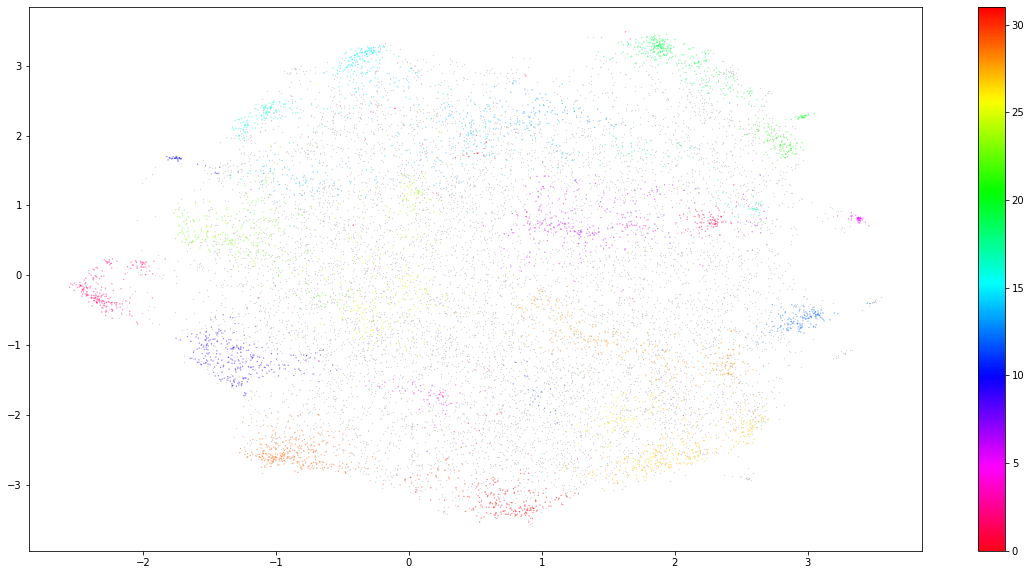

In [34]:
%time

import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(
    n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [35]:
len(clustered)

4015

In [36]:
len(outliers)

9271

In [79]:
clustered.to_csv('../data/tmp/clustered.csv', index=False)

- Top2Vec - https://github.com/ddangelov/Top2Vec

In [12]:
docs_df = pd.DataFrame(texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [13]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(texts))

In [14]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes

,Topic,Size
0,-1,9045
9,8,353
34,33,306
36,35,274
19,18,274
22,21,244
5,4,240
38,37,222
6,5,217
33,32,213


In [15]:
top_n_words[0]

[('chléb', 0.027851611198559296),
 ('probíhej', 0.013605795309301989),
 ('stave', 0.013409349350959244),
 ('hebounké', 0.013173755774385822),
 ('člunku', 0.013069408598702025),
 ('chleba', 0.01305204248278649),
 ('klep', 0.012133581869688834),
 ('nitě', 0.011489611469328743),
 ('potlesk', 0.01140559784889354),
 ('chutě', 0.01023532056479106),
 ('hbitě', 0.009912856695489646),
 ('chcem', 0.00752208671327769),
 ('svůj', 0.007453430641180646),
 ('žebrák', 0.007090340086111388),
 ('drahý', 0.006930044384715717),
 ('davů', 0.006671636722411554),
 ('vždyť', 0.0060221051811038834),
 ('tvrdé', 0.005800065122340442),
 ('krajíc', 0.00568088568353837),
 ('chleby', 0.005570231950267583)]

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(texts)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,9705
6,5,353
17,16,306
18,17,274
10,9,274
12,11,244
3,2,240
19,18,222
4,3,217
16,15,213


In [25]:
top_n_words[0]

[('víno', 0.016669159156315987),
 ('pivo', 0.013735918078685665),
 ('vína', 0.009322787487880974),
 ('sudaku', 0.007710751440551056),
 ('falstaff', 0.006757830299770727),
 ('žij', 0.006073889445170981),
 ('šampaňské', 0.005743237117488804),
 ('leporello', 0.004690120704355406),
 ('seňoro', 0.004505220199847152),
 ('číši', 0.0043488643109345386),
 ('pije', 0.004342283481751218),
 ('pil', 0.004303714829436251),
 ('li', 0.004179433322095424),
 ('nápoj', 0.00411265628232456),
 ('hospody', 0.003980825800188657),
 ('nektarem', 0.0038970528959062865),
 ('fousek', 0.003713042496503799),
 ('kdo', 0.0037044495305717656),
 ('píte', 0.003638735106854603),
 ('vínem', 0.0036185695681260144)]

# BERTopic
- BERTopic - https://towardsdatascience.com/meet-bertopic-berts-cousin-for-advanced-topic-modeling-ea5bf0b7faa3

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
texts_joined = []

for text in texts:
    texts_joined.append(' '.join(text.split('\n')))
    
texts_joined[0]

'Je-li v domě hezká dcera,  je tam věru jako v krámě. Od rána až do večera veselo je panímámě. Krásné děvče, štědré věno nestřežené závorami – komu bude usouzeno, šťastný hochu! sdílej s námi!'

In [20]:
from bertopic import BERTopic

model = BERTopic(verbose=True,embedding_model='distiluse-base-multilingual-cased-v2', min_topic_size= 7)
headline_topics, _ = model.fit_transform(texts)

Batches:   0%|          | 0/416 [00:00<?, ?it/s]

2022-05-16 23:53:55,260 - BERTopic - Transformed documents to Embeddings
2022-05-16 23:54:03,717 - BERTopic - Reduced dimensionality
2022-05-16 23:54:04,459 - BERTopic - Clustered reduced embeddings


In [21]:
freq = model.get_topic_info()
print("Number of topics: {}".format(len(freq)))
freq.head()

Number of topics: 151


,Topic,Count,Name
0,-1,7784,-1_se_na_jak_to
1,0,383,0_píseň_písní_srdce_písně
2,1,308,1_růže_květ_srdce_květy
3,2,258,2_hvězdy_noc_se_hvězda
4,3,228,3_se_na_do_jak


In [22]:
a_topic = freq.iloc[1]["Topic"] # Select the 1st topic
model.get_topic(a_topic) # Show the words and their c-TF-IDF scores

[('píseň', 0.01453781046363476),
 ('písní', 0.006446695230148631),
 ('srdce', 0.006349589326347434),
 ('písně', 0.006125738092732786),
 ('má', 0.005686013423301519),
 ('jak', 0.0056511933087556535),
 ('když', 0.005515668034517476),
 ('se', 0.005396392717960931),
 ('mé', 0.005142914875709461),
 ('mi', 0.0048774209706100285)]

In [23]:
freq

,Topic,Count,Name
0,-1,7784,-1_se_na_jak_to
1,0,383,0_píseň_písní_srdce_písně
2,1,308,1_růže_květ_srdce_květy
3,2,258,2_hvězdy_noc_se_hvězda
4,3,228,3_se_na_do_jak
...,...,...,...
141,146,7,146_neplač_hněsti_jiné_nevzpomínat
140,147,7,147_roman_hoře_mu_řekla
139,148,7,148_filo_jsme_balbe_zatančit
138,143,7,143_líto_sluníčko_štěstí_křižáků


In [24]:
# Select most 3 similar topics
similar_topics, similarity = model.find_topics("dívka", top_n = 3)

most_similar = similar_topics[0]
print("Most Similar Topic Info: \n{}".format(model.get_topic(most_similar)))
print("Similarity Score: {}".format(similarity[0]))

Most Similar Topic Info: 
[('ženo', 0.09389545215243683), ('pohlavím', 0.025769064838334653), ('vzít', 0.017298286756611162), ('pohlaví', 0.015369915685117523), ('ženy', 0.014534121366486874), ('ženu', 0.013284157242738959), ('já', 0.01261760782963604), ('ach', 0.012325425212550483), ('má', 0.012250265223851252), ('ťuk', 0.010722531436142014)]
Similarity Score: 0.7836140992538645
